- Useful link: [pydata 2021](https://www.youtube.com/watch?v=ODspi8-uWgo)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error

In [2]:
initial_df = pd.read_csv("../data/processed_data/sales_2019.csv",
                         parse_dates=["OrderDate"])

In [3]:
initial_df.head(2)

,OrderID,Product,QuantityOrdered,PriceEach,OrderDate,PurchaseAddress,Sales,Hour,Month,Day,DayName,Year,StreetAddress,CityName,ZipAddress,StreetName,StreetNumber,ZipCode,StateCode
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,8,4,19,Friday,2019,917 1st St,Dallas,TX 75001,1st St,917,75001,TX
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,22,4,7,Sunday,2019,682 Chestnut St,Boston,MA 02215,Chestnut St,682,2215,MA


In [4]:
df = initial_df.set_index(keys=["OrderDate"])

- Resampling the data to daily and splitting the data into train and test

In [5]:
X_train, X_test = temporal_train_test_split(y=df["Sales"].resample("D").sum(), test_size=0.15)

- Dropping the first date of 2020-01-01 because it is an incomplete observation

In [6]:
X_test = X_test.drop(index="2020-01-01")

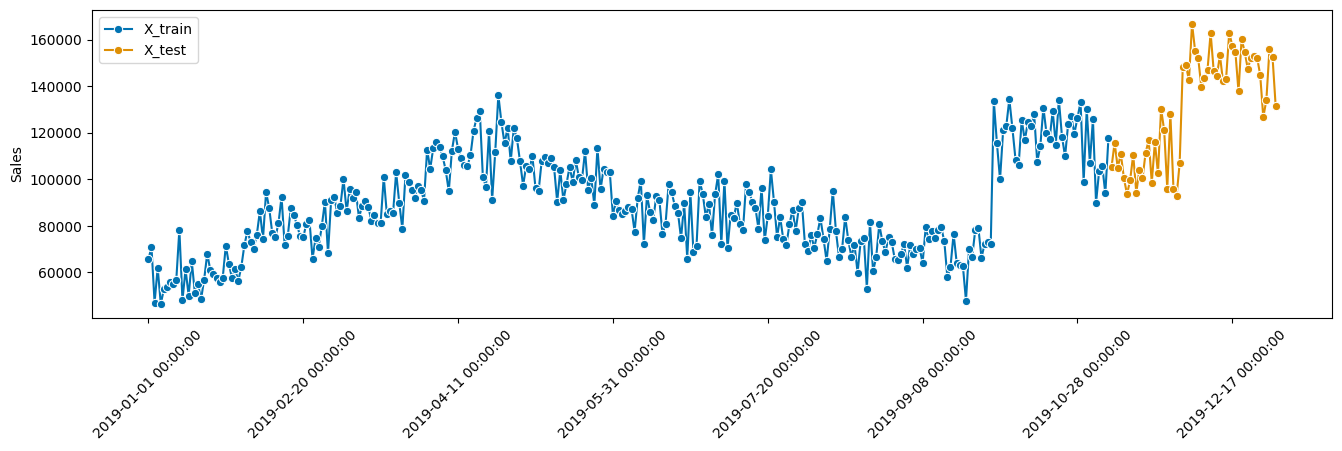

In [7]:
plot_series(X_train, X_test, labels=["X_train", "X_test"])
plt.xticks(rotation=45);

## Seasonality & Trend

<Figure size 1000x1000 with 0 Axes>

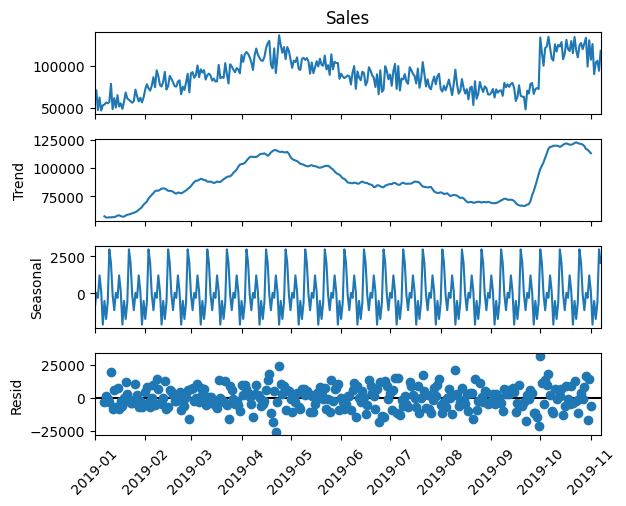

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(10, 10))
result = seasonal_decompose(X_train, model='additive', period=12)
result.plot()
plt.xticks(rotation=45);

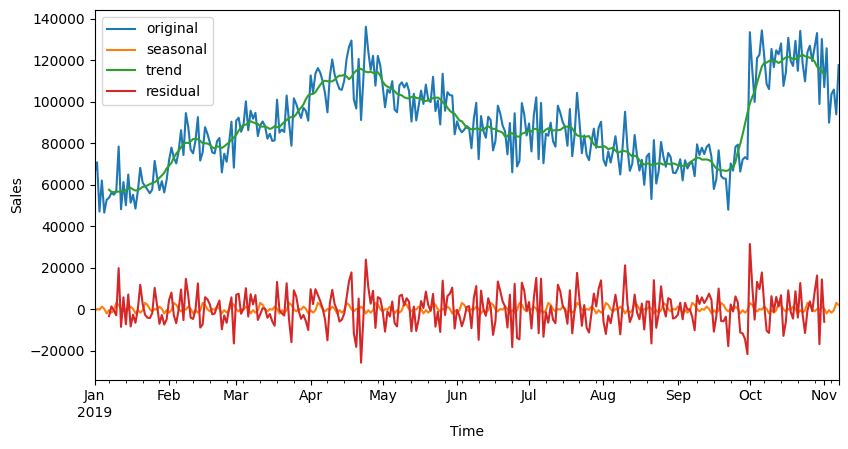

In [15]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.5))
X_train.plot(ax=ax, label="original")
result.seasonal.plot(ax=ax, label="seasonal")
result.trend.plot(ax=ax, label="trend")
result.resid.plot(ax=ax, label="residual")
ax.set(xlabel="Time", ylabel="Sales")
plt.legend();

<Axes: >

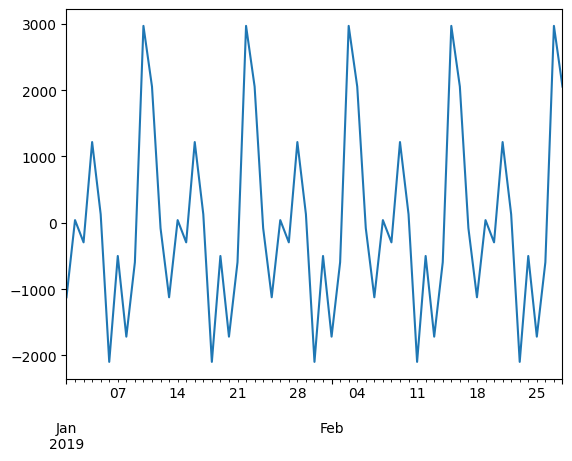

In [18]:
result.seasonal.loc["2019-01-01":"2019-02"].plot()

- We have a seasonal pattern that is not linear.
- With a period of 14 days.

## Autocorrelation

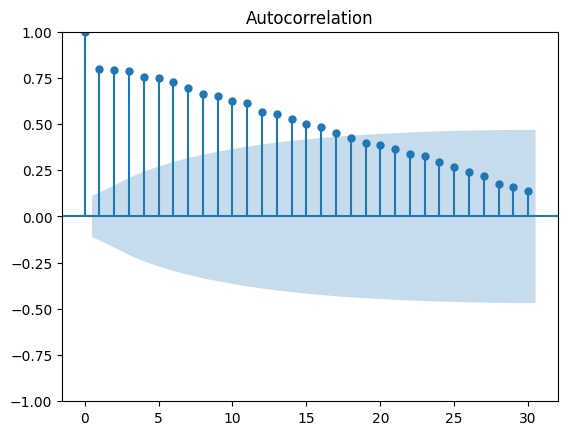

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(X_train, lags=30, alpha=0.05)
plt.show()

- ACF can be used to find the order of the order of the MA(q) model
- It shows that the sales are highly correlated with the past sales.

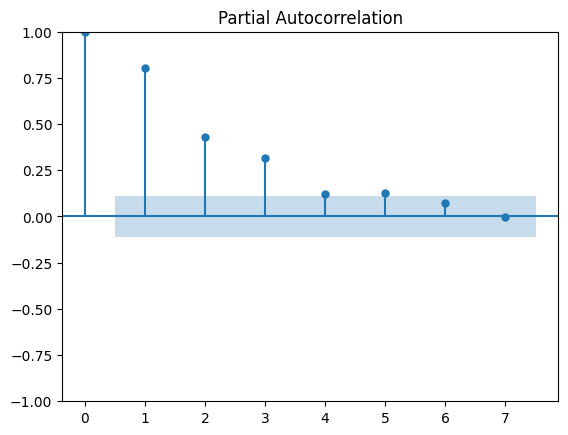

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(X_train, lags=7,
          alpha=0.05,
          method='ols'
          )
plt.show()

- PACF can be used to find the order of the order of the *AR(p)* model
- A It shows that the sales at one day are highly correlated with the sales at the 3 previous day.

## To Sum Up
- The sales are highly correlated with the past sales.
- The sales at one day are highly correlated with the sales at the 3 previous day.
- Autoregressive model may be a good choice to predict the sales.


In [21]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

In [25]:
from sktime.forecasting.base import BaseForecaster
class SalesForecaster:
    def __init__(self, forecaster: BaseForecaster):
        """
        A class of forecaster to predict sales

        Args:
            forecaster (BaseForecaster): The forecaster to predict sales
        """
        self.forecaster = forecaster
        
    def fit(self, data):
        self.forecaster.fit(data)
        
    def predict(self, fh: ForecastingHorizon):
        return self.forecaster.predict(fh)
    
    def evaluate_and_plot(self, y_pred, X_test, error_pred):
        self.plot_predictions(X_test, y_pred, error_pred)
        self.print_metrics(X_test, y_pred)
        
    def fit_and_predict(self, data, fh, y_test):
        self.fit(data)
        y_pred = self.predict(fh)
        error_pred = y_test - y_pred
        self.evaluate_and_plot(y_test, y_pred, error_pred)
        return y_pred
    
    def plot_predictions(self, data, y_pred, error_pred):
        plot_series(data, y_pred,error_pred, labels=["Actual", "Predicted", "Error"])
        plt.xticks(rotation=45)
        plt.show()
        
    def print_metrics(self, X_test, y_pred):
        mae = mean_absolute_error(X_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(X_test, y_pred)
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape}")

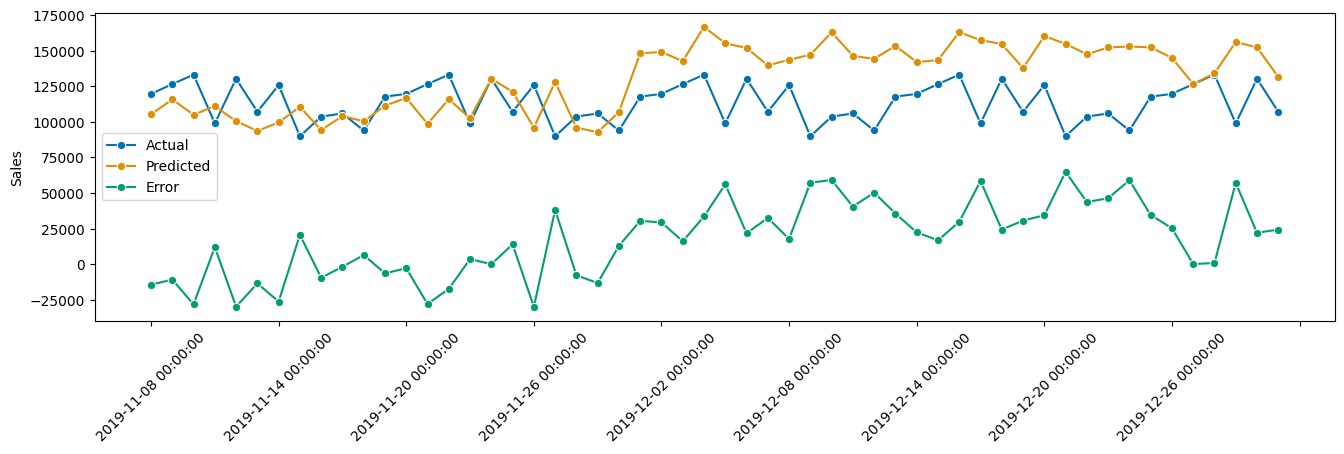

Mean Absolute Error (MAE): 26349.29018518519
Mean Absolute Percentage Error (MAPE): 0.24395121806231043


In [26]:
# step 1: data specification

# step 2: specifying forecasting horizon
fh = ForecastingHorizon(X_test.index, is_relative=False)

# step 3: specifying the forecasting algorithm
# With the seasonal parameter set to 7
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
NaiveSalesForecaster = SalesForecaster(forecaster)

# step 5: querying predictions
y_pred = NaiveSalesForecaster.fit_and_predict(X_train, fh, X_test)

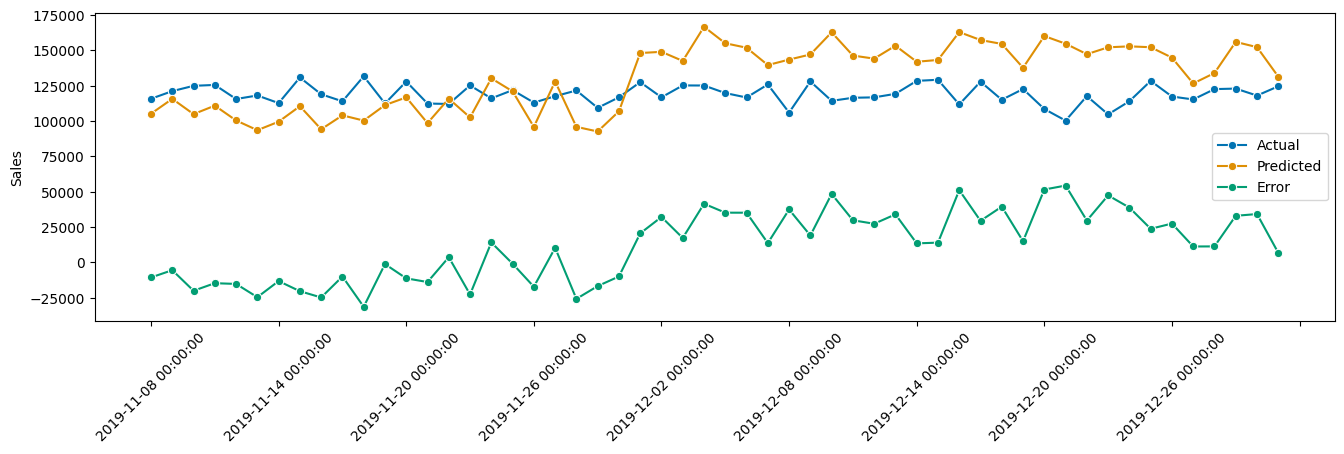

Mean Absolute Error (MAE): 23377.24769408894
Mean Absolute Percentage Error (MAPE): 0.19961603120273555


In [91]:
regressor = HistGradientBoostingRegressor(max_depth=30, max_bins=255, max_iter=1000,
                                          random_state=0,learning_rate=0.1, l2_regularization=0.001)
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
hist_forecaster = SalesForecaster(forecaster)

y_pred = hist_forecaster.fit_and_predict(X_train, fh, X_test)

In [286]:
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import BaggingForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
forecaster = BaggingForecaster(
    STLBootstrapTransformer(sp=12),
    NaiveForecaster(sp=7, strategy="last"),
    PolynomialTrendForecaster(degree=2),
)

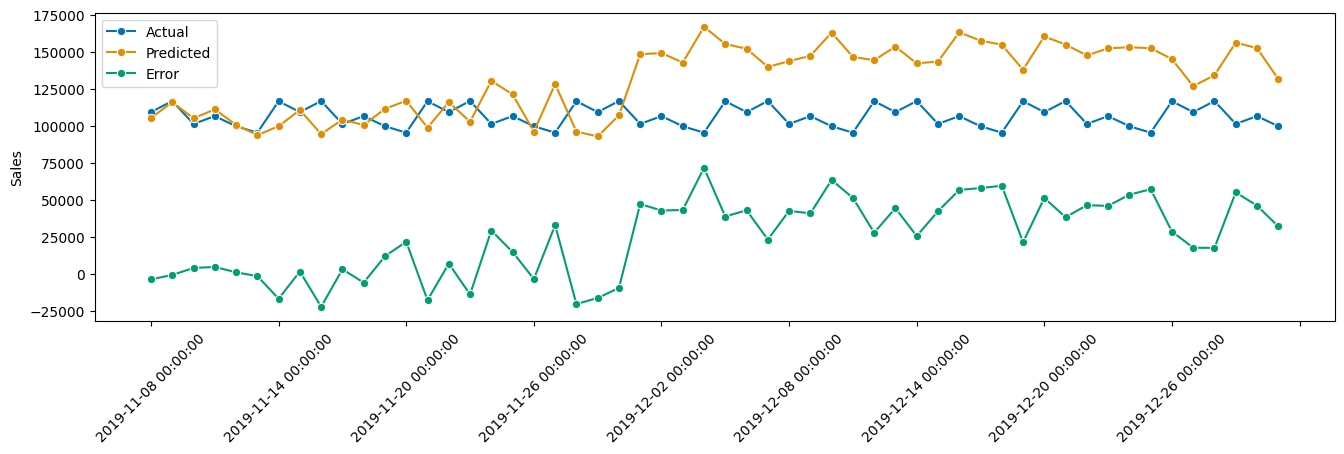

Mean Absolute Error (MAE): 29493.990555953384
Mean Absolute Percentage Error (MAPE): 0.28317795834852233


2019-11-08    109093.866135
2019-11-09    116598.129312
2019-11-10    101123.792704
2019-11-11    106405.204783
2019-11-12     99548.661864
2019-11-13     95223.511617
2019-11-14    116478.275841
2019-11-15    109093.866135
2019-11-16    116598.129312
2019-11-17    101123.792704
2019-11-18    106405.204783
2019-11-19     99548.661864
2019-11-20     95223.511617
2019-11-21    116478.275841
2019-11-22    109093.866135
2019-11-23    116598.129312
2019-11-24    101123.792704
2019-11-25    106405.204783
2019-11-26     99548.661864
2019-11-27     95223.511617
2019-11-28    116478.275841
2019-11-29    109093.866135
2019-11-30    116598.129312
2019-12-01    101123.792704
2019-12-02    106405.204783
2019-12-03     99548.661864
2019-12-04     95223.511617
2019-12-05    116478.275841
2019-12-06    109093.866135
2019-12-07    116598.129312
2019-12-08    101123.792704
2019-12-09    106405.204783
2019-12-10     99548.661864
2019-12-11     95223.511617
2019-12-12    116478.275841
2019-12-13    109093

In [265]:
bagging_forecaster = SalesForecaster(forecaster)
bagging_forecaster.fit_and_predict(X_train, fh, X_test)

In [18]:
y_pred = forecaster.predict(fh=fh) 

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(-50.0, 0, ''),
  Text(0.0, 0, '2019-01-01 00:00:00'),
  Text(50.0, 0, '2019-02-20 00:00:00'),
  Text(100.0, 0, '2019-04-11 00:00:00'),
  Text(150.0, 0, '2019-05-31 00:00:00'),
  Text(200.0, 0, '2019-07-20 00:00:00'),
  Text(250.0, 0, '2019-09-08 00:00:00'),
  Text(300.0, 0, '2019-10-28 00:00:00'),
  Text(350.0, 0, '2019-12-17 00:00:00'),
  Text(400.0, 0, '')])

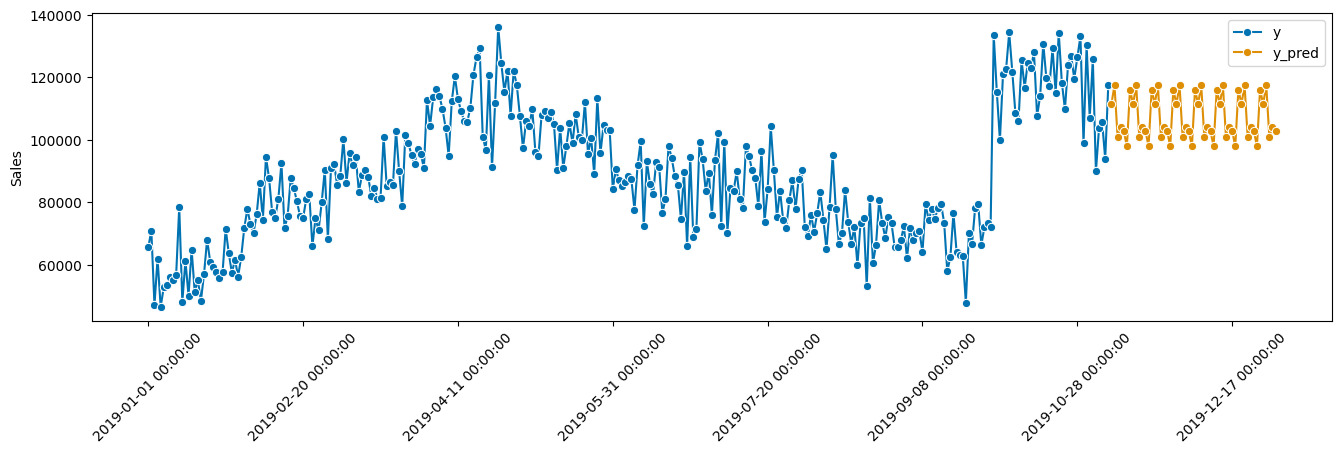

In [21]:
from sktime.utils.plotting import plot_series
plot_series(X_train,X_test, y_pred, labels=["y","y_test", "y_pred"])
plt.xticks(rotation=45)

In [24]:
y_test_pred = forecaster.predict(fh=ForecastingHorizon(X_test.index, is_relative=False))  

(array([-6.,  0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 [Text(-6.0, 0, ''),
  Text(0.0, 0, '2019-11-08 00:00:00'),
  Text(6.0, 0, '2019-11-14 00:00:00'),
  Text(12.0, 0, '2019-11-20 00:00:00'),
  Text(18.0, 0, '2019-11-26 00:00:00'),
  Text(24.0, 0, '2019-12-02 00:00:00'),
  Text(30.0, 0, '2019-12-08 00:00:00'),
  Text(36.0, 0, '2019-12-14 00:00:00'),
  Text(42.0, 0, '2019-12-20 00:00:00'),
  Text(48.0, 0, '2019-12-26 00:00:00'),
  Text(54.0, 0, ''),
  Text(60.0, 0, '')])

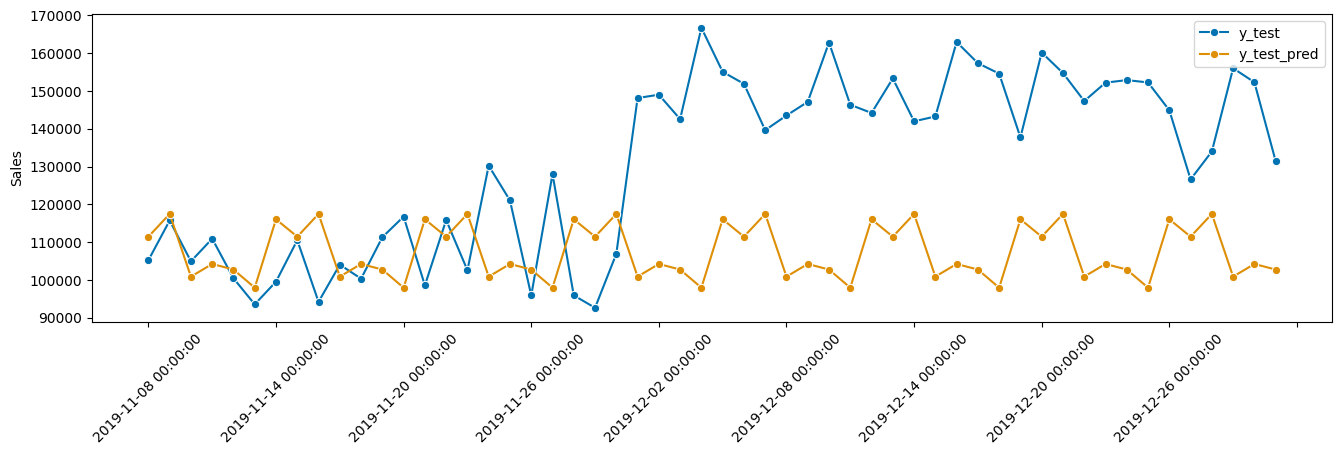

In [25]:
plot_series(X_test, y_test_pred, labels=["y_test", "y_test_pred"])
plt.xticks(rotation=45)

(array([-6.,  0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 [Text(-6.0, 0, ''),
  Text(0.0, 0, '2019-11-08 00:00:00'),
  Text(6.0, 0, '2019-11-14 00:00:00'),
  Text(12.0, 0, '2019-11-20 00:00:00'),
  Text(18.0, 0, '2019-11-26 00:00:00'),
  Text(24.0, 0, '2019-12-02 00:00:00'),
  Text(30.0, 0, '2019-12-08 00:00:00'),
  Text(36.0, 0, '2019-12-14 00:00:00'),
  Text(42.0, 0, '2019-12-20 00:00:00'),
  Text(48.0, 0, '2019-12-26 00:00:00'),
  Text(54.0, 0, ''),
  Text(60.0, 0, '')])

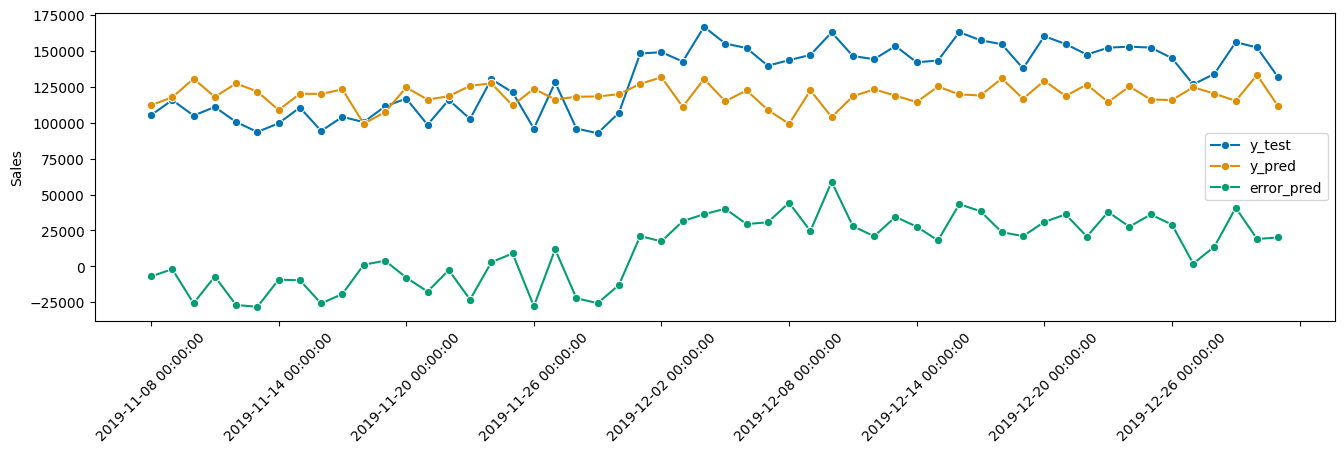

In [61]:
error_pred = X_test - y_pred
plot_series(X_test, y_pred, error_pred, labels=["y_test", "y_pred", "error_pred"])
plt.xticks(rotation=45)

In [155]:
X_train.loc[:"2020-06-01"]

2019-01-01     65681.94
2019-01-02     70813.20
2019-01-03     47046.20
2019-01-04     62012.21
2019-01-05     46524.63
                ...    
2019-10-15    107623.75
2019-10-16    114107.87
2019-10-17    130827.84
2019-10-18    119705.72
2019-10-19    117261.52
Freq: D, Name: Sales, Length: 292, dtype: float64

C:\Users\MahamadiNikiema\AppData\Local\Temp\ipykernel_6896\2602837039.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


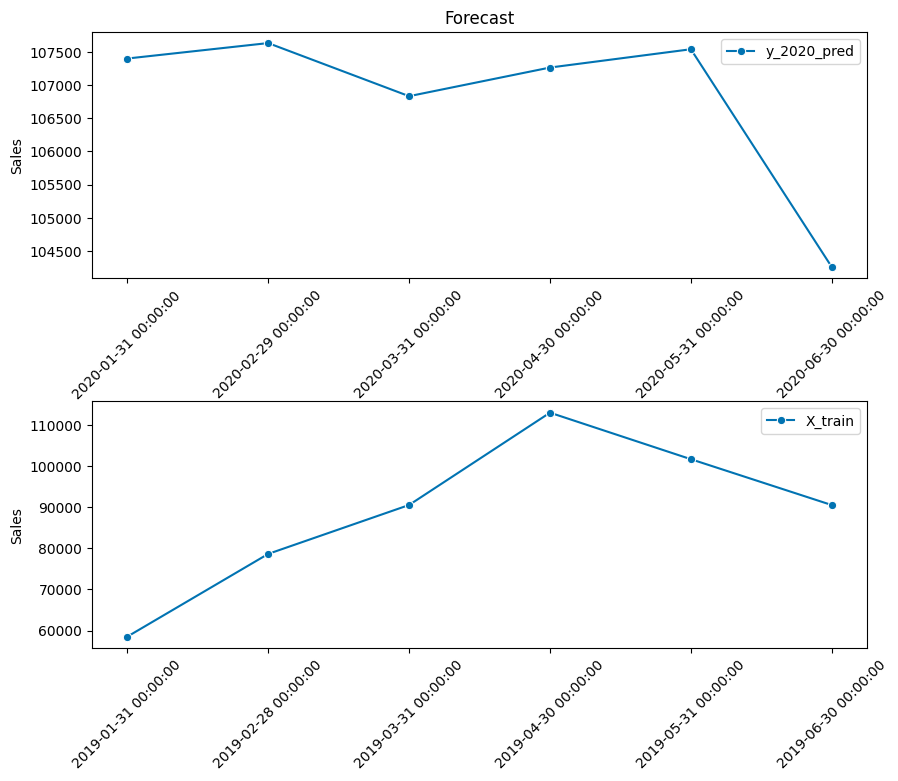

In [26]:
start_date = '2020-01-01'
end_date = '2020-06-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
fh_2020 = ForecastingHorizon(date_range, is_relative=False)
y_2020_pred = forecaster.predict(fh=fh_2020)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_series(y_2020_pred.resample('M').mean(), labels=["y_2020_pred"], ax=ax1)
ax1.set_title("Forecast")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
plot_series(X_train.loc[:"2019-06-01"].resample('M').mean(), labels=["X_train"], ax=ax2)
plt.xticks(rotation=45)
fig.subplots_adjust(hspace=0.5)

## ARIMA Forecast

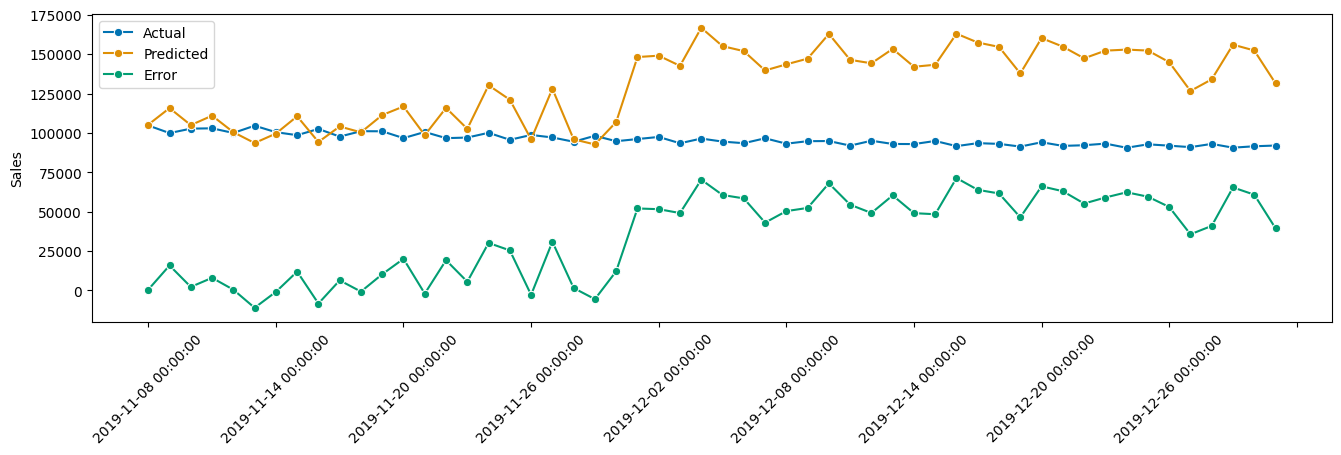

Mean Absolute Error (MAE): 36167.142099772886
Mean Absolute Percentage Error (MAPE): 0.3853614973926592


In [78]:
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA(order=(5, 0, 9), suppress_warnings=True)
arima_forecaster = SalesForecaster(forecaster)

y_pred = arima_forecaster.fit_and_predict(X_train, fh, X_test)

## Evaluation

In [111]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter, SlidingWindowSplitter, ForecastingGridSearchCV
import numpy as np
cv = ExpandingWindowSplitter(
    fh=[2,4,8],
    initial_window=30,
    step_length=7,
)

forecaster = NaiveForecaster(strategy="last", sp=12)
result_cv = evaluate(
    forecaster,
    cv=cv,
    y=X_train,
    return_data=True
)

In [112]:
regressor = HistGradientBoostingRegressor()
param_grid = {"estimator__max_depth": [30, 50,80],
              "estimator__max_iter": [1000], "max_bins": [100,255],
              "estimator__learning_rate": [0.1, 0.01, 0.001],
              "estimator__l2_regularization": [0.1, 0.01, 0.001]}
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
cv = SlidingWindowSplitter(
    fh=[2,4,8],
    initial_window=30,
    step_length=7
)

In [116]:
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv
)
gscv.fit(X_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[2, 4, 8],
                                                 initial_window=30,
                                                 step_length=7),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(),
                                                                        window_length=5),
                        param_grid={'estimator__l2_regularization': [0.1, 0.01,
                                                                     0.001],
                                    'estimator__learning_rate': [0.1, 0.01,
                                                                 0.001],
                                    'estimator__max_depth': [30, 50, 80],
                                    'estimator__max_iter': [1000],
                                    'max_bins': [100, 255]})

In [117]:
gscv.best_params_

{'estimator__l2_regularization': 0.1,
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': 30,
 'estimator__max_iter': 1000,
 'max_bins': 100}

In [119]:
y_pred = gscv.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Sales'>)

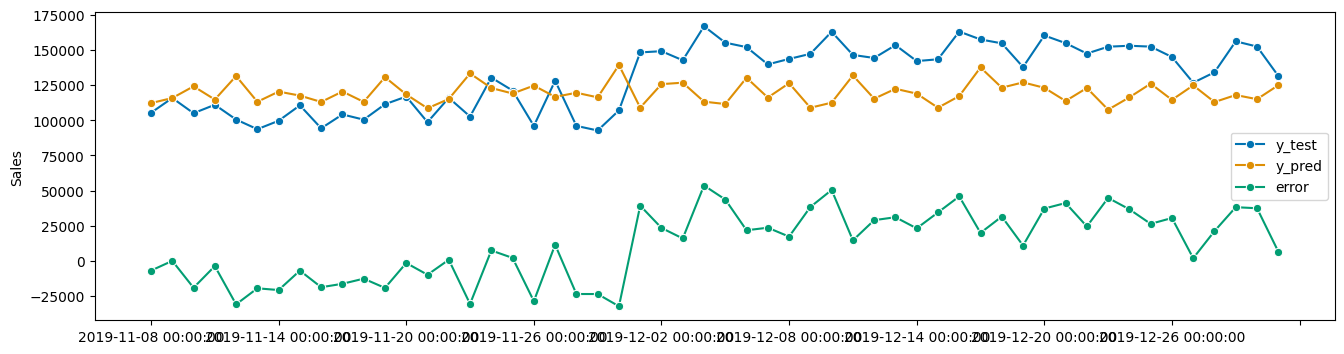

In [122]:
plot_series(X_test, y_pred,X_test-y_pred, labels=["y_test", "y_pred", "error"])

## Feature Transformation

In [275]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.difference import Differencer
regressor = HistGradientBoostingRegressor(max_depth=30, max_bins=255, max_iter=1000,
                                          random_state=0,learning_rate=0.1, l2_regularization=0.001)
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
pipe = TransformedTargetForecaster(steps=[
    ("differencer", Differencer(lags=1)),
    ("deseasonalizer", Deseasonalizer(model="additive", sp=12)),
    ("forecaster", forecaster),
])
pipe.fit(X_train)

TransformedTargetForecaster(steps=[('differencer', Differencer()),
                                   ('deseasonalizer', Deseasonalizer(sp=12)),
                                   ('forecaster',
                                    RecursiveTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(l2_regularization=0.001, max_depth=30,
                              max_iter=1000, random_state=0),
                                                                         window_length=5))])

In [283]:
y_pred = pipe.predict(fh)
print(mean_absolute_error(X_test, y_pred))

13778.593277948221


(array([-6.,  0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 [Text(-6.0, 0, ''),
  Text(0.0, 0, '2019-11-08 00:00:00'),
  Text(6.0, 0, '2019-11-14 00:00:00'),
  Text(12.0, 0, '2019-11-20 00:00:00'),
  Text(18.0, 0, '2019-11-26 00:00:00'),
  Text(24.0, 0, '2019-12-02 00:00:00'),
  Text(30.0, 0, '2019-12-08 00:00:00'),
  Text(36.0, 0, '2019-12-14 00:00:00'),
  Text(42.0, 0, '2019-12-20 00:00:00'),
  Text(48.0, 0, '2019-12-26 00:00:00'),
  Text(54.0, 0, ''),
  Text(60.0, 0, '')])

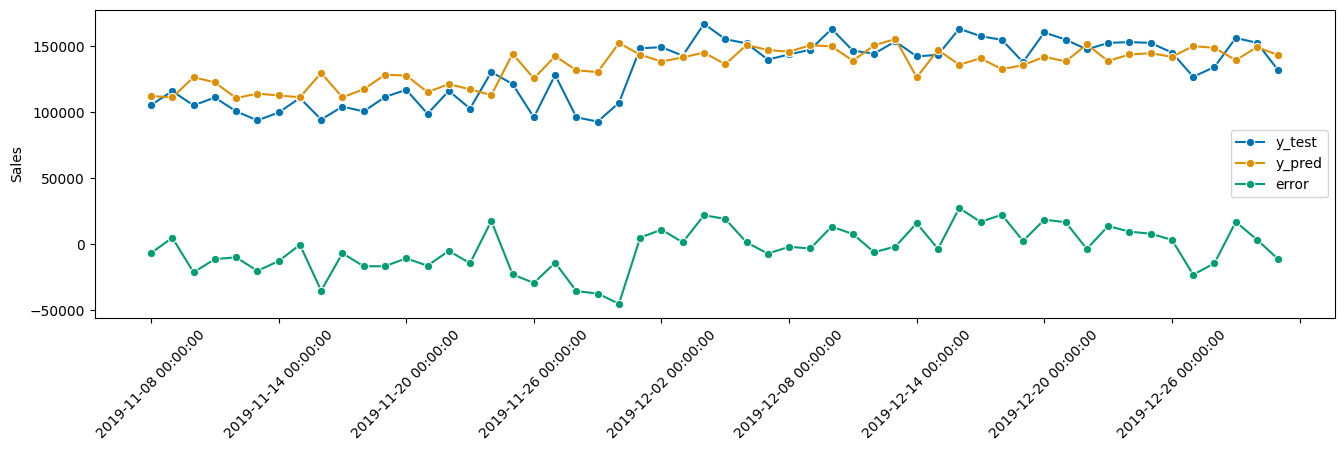

In [277]:
plot_series(X_test, y_pred,X_test-y_pred, labels=["y_test", "y_pred", "error"])
plt.xticks(rotation=45)

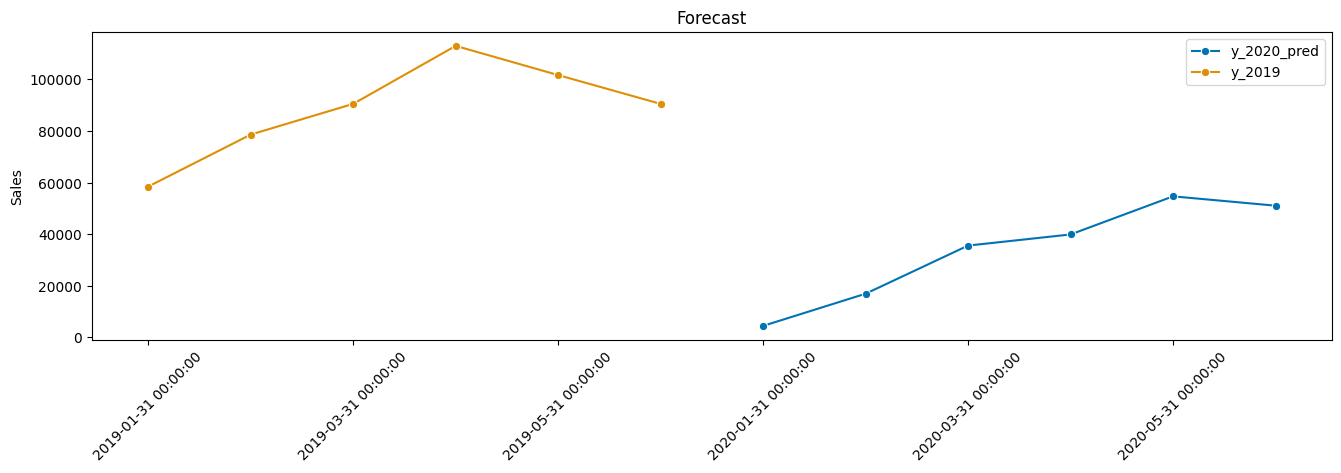

In [217]:
start_date = '2020-01-01'
end_date = '2020-06-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
fh_2020 = ForecastingHorizon(date_range, is_relative=False)
y_2020_pred = pipe.predict(fh=fh_2020)
plot_series(y_2020_pred.resample('M').mean(),X_train.loc[:"2019-06-01"].resample('M').mean(),
            labels=["y_2020_pred","y_2019"])
plt.title("Forecast")
plt.xticks(rotation=45)
fig.subplots_adjust(hspace=0.5)

In [224]:
(X_test-y_pred).mean()

-3572.8276303747525

## Add exogen variables

In [279]:
from sktime.transformations.series.holiday import CountryHolidaysTransformer

transformer = CountryHolidaysTransformer("US")
transformer.fit(X_train)
X_train_holidays = transformer.transform(X_train)
X_train_holidays.index = X_train.index

In [280]:
pipe.fit(X_train,X_train_holidays)

TransformedTargetForecaster(steps=[('differencer', Differencer()),
                                   ('deseasonalizer', Deseasonalizer(sp=12)),
                                   ('forecaster',
                                    RecursiveTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(l2_regularization=0.001, max_depth=30,
                              max_iter=1000, random_state=0),
                                                                         window_length=5))])

In [285]:
exo_test = CountryHolidaysTransformer("US").fit_transform(X_test)
exo_test.index = X_test.index
y_pred = pipe.predict(fh, exo_test)
print(mean_absolute_error(X_test, y_pred))

13778.593277948221


- Adding exogenous variables does not improve the prediction